## Fitting a global pitch angle for a galaxy

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gzbuilderspirals import pa_from_r_theta, xy_from_r_theta
from gzbuilderspirals.oo import Pipeline, Arm
from gzbuilderspirals.deprojecting import reproject_arm
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [2]:
sid = 20902040
arms = [Arm.load('lib/spiral_arms/{}'.format(f)) for f in os.listdir('lib/spiral_arms/') if str(sid) in f]
arms

In [3]:
def lsp(A, pa, t):
  return A * np.exp(pa * np.pi / 180 * t)

pipeline = arms[0].get_parent()

def f(p):
  As = p[:-1]
  phi = p[-1]
  return sum(
      mean_squared_error(
          a.R,
          lsp(As[i], phi, a.t),
          sample_weight=a.point_weights
      )
      for i, a in enumerate(arms)
  )

gal_pa, gal_sigma_pa = pipeline.get_pitch_angle(arms)

res_comb = minimize(f, [0.1]*len(arms) + [gal_pa * arms[0].chirality])

Combined fit: -10.830572036024153˚
Length-weighted average fit: -11.990463429498838˚ ± 2.8869182115297676


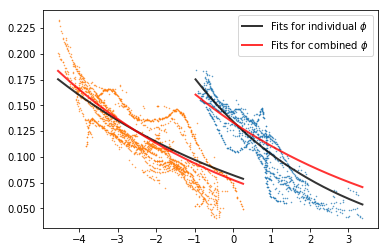

In [4]:
INDIV_KW = {'color': 'k', 'linewidth': 2, 'alpha': 0.8}
COMBI_KW = {'color': 'r', 'linewidth': 2, 'alpha': 0.8}

for a in arms:
  plt.plot(a.t, a.R, '.', alpha=0.8, markersize=1)

for i, a in enumerate(arms):
    o = np.argsort(a.t)
    plt.plot(*a.polar_logsp, **INDIV_KW)
    plt.plot(
        a.t[o],
        lsp(res_comb['x'][i], res_comb['x'][-1], a.t[o]),
        **COMBI_KW
    )

plt.plot([], [], **INDIV_KW, label='Fits for individual $\phi$')
plt.plot([], [], 'r', **COMBI_KW, label='Fits for combined $\phi$')

print('Combined fit: {}˚'.format(res_comb['x'][-1]))
print('Length-weighted average fit: {}˚ ± {}'.format(arms[0].chirality * gal_pa, np.std([a.pa for a in arms])))
plt.legend()

In [5]:
import lib.galaxy_utilities as gu
gal, angle = gu.get_galaxy_and_angle(sid)
pic_array, deprojected_image = gu.get_image(gal, sid, angle)
pix_size = pic_array.shape[0] / (gal['PETRO_THETA'].iloc[0] * 4)
kw = {
    'cmap': 'gray_r', 'origin': 'lower',
    'extent': (
        -pic_array.shape[0]/2 / pix_size,
        pic_array.shape[0]/2 / pix_size,
        -pic_array.shape[1]/2 / pix_size,
        pic_array.shape[1]/2 / pix_size
    ),
}

In [6]:
pix_size

5.014432260045342

Combined fit: -10.830572036024153˚
Length-weighted average fit: -11.990463429498838˚ ± 2.8869182115297676


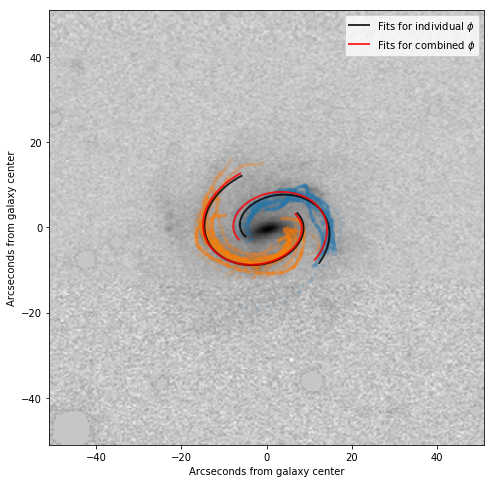

In [7]:
plt.figure(figsize=(8, 8))
plt.imshow(pic_array, **kw)
tc = lambda v: (v - pic_array.shape[0] / 2) / pix_size
for i, a in enumerate(arms):
    o = np.argsort(a.t)
    foo = reproject_arm(
        arm=xy_from_r_theta(
          lsp(res_comb['x'][i], res_comb['x'][-1], a.t[o]),
          a.t[o],
        ).T,
        angle=a.phi,
        ba=a.ba
    )
    plt.plot(*tc(a.coords.T), '.', alpha=0.1)
    plt.plot(*tc(a.reprojected_log_spiral.T), **INDIV_KW)
    plt.plot(*foo.T * 512 /pix_size, **COMBI_KW)

plt.plot([], [], **INDIV_KW, label='Fits for individual $\phi$')
plt.plot([], [], 'r', **COMBI_KW, label='Fits for combined $\phi$')

print('Combined fit: {}˚'.format(res_comb['x'][-1]))
print('Length-weighted average fit: {}˚ ± {}'.format(arms[0].chirality * gal_pa, np.std([a.pa for a in arms])))
plt.legend()
plt.xlabel('Arcseconds from galaxy center')
plt.ylabel('Arcseconds from galaxy center');
plt.savefig('method-paper-plots/uniform-galaxy-pa.pdf', bbox_inches='tight')